 # Introduction to Computer Vision - Fall 2025

# Assignment 1

## Detecting and Counting Coins

**Goal:** Build an image-processing pipeline that **segments coins** and **estimates how many coins** are present **without using contours or connected components**.  
Students are asked to use the techniques covered in the Labs 1, 2, and 3

**What you will practice:**
- Point operations
- Neighborhood operations
- Histograms
- Thresholding
- Morphological operations

## Lane Edges Detection
**Goal:** Build an edge detection algorithm to detect the lanes and then apply a mask to select the region of interest (ROI), specifically the road itself.
Students are asked to use the techniques covered in the Labs 1, 2, and 3

**What you will practice:**
- noise cancellation
- cany edge detector

**Constraint:** Do **not** use `findContours`, `connectedComponents`,`cv2.Canny`, or similar labeling functions.  

Code should be well documented (explain your logic)

Plagiarism in code -> 0

AI generated code -> 0

Late submission 5% per day

Submit your completed Colab notebook.


## Detecting and Counting Coins

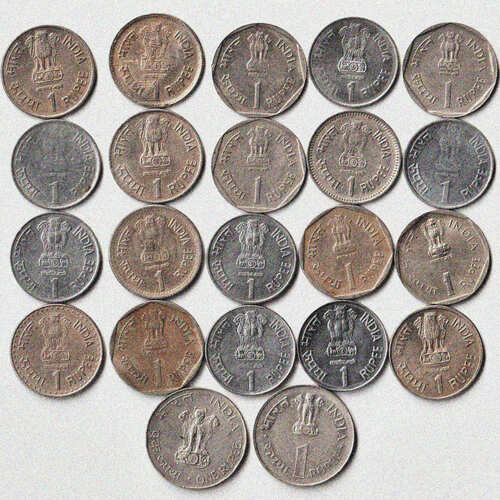

In [1]:
# Download the image
!wget -O coins.jpg "https://drive.google.com/uc?export=download&id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1"

--2025-09-18 06:54:36--  https://drive.google.com/uc?export=download&id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1
Resolving drive.google.com (drive.google.com)... 64.233.188.138, 64.233.188.113, 64.233.188.101, ...
Connecting to drive.google.com (drive.google.com)|64.233.188.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1&export=download [following]
--2025-09-18 06:54:36--  https://drive.usercontent.google.com/download?id=1CwHqnRK1ZiTTfc4B9ofZD4HJPbqfrnQ1&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c07::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4104743 (3.9M) [image/jpeg]
Saving to: ‘coins.jpg’

coins.jpg           100%[===================>]   3.91M  --.-KB/s    in 0.02s   



In [2]:
# Helper function
# I replaced it by the one that we had in labs ipynb
import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (22.5, 10.5)

def showInRow(list_of_images, titles=None):
  count = len(list_of_images)
  for idx in range(count):
    subplot = plt.subplot(1, count, idx + 1)
    if titles is not None:
      subplot.set_title(titles[idx])
    img = list_of_images[idx]
    cmap = 'gray' if (len(img.shape) == 2 or img.shape[2] == 1) else None
    subplot.imshow(img, cmap=cmap)
  plt.show()

## **Explanation of the Process**

1. **Loading the image**
I started with a color image of coins. Since most processing is easier in grayscale, I immediately converted the image to gray. This reduces complexity (only one channel instead of three) and makes thresholding possible.

1. **Noise reduction**
Before thresholding, I applied a Gaussian blur with kernel size `(5,5)`. This smooths out small noise and prevents isolated bright pixels from being misclassified as edges or coins later.

1. **Binarization**
I used Otsu's thresholding to automatically choose a threshold and separate the coins (foreground) from the background. The result is a binary image with coins in black and background in white. However, the coins were not completely clean: they had gaps and extra noise.

1. **Morphological cleaning**
First, I applied **opening** (erosion followed by dilation) with a small elliptical kernel `(3,3)`. This removed small speckles of noise inside the coins.
Then, I used **erosion** with a larger kernel `(9,9)` to completely remove noises inside coins.

1. **Filling internal gaps**
To remove small holes inside the coins, I applied a strong **median blur** with kernel size `27`. This smoothed the shapes, so the coins became solid areas.

1. **Mask preparation**
At this point the coins were black on white background, but I needed the opposite. I inverted the binary mask using `cv2.bitwise_not`.

1. **Primitive distance transform**
I could not use `cv2.distanceTransform`, so I implemented a simplified version:

* Repeatedly apply erosion with a small kernel.
* Each time a pixel survives erosion, increase its depth value.
* The more iterations a pixel survives, the further it is from the boundary.
This produces a "depth map" that works similarly to a distance transform.

8. **Peak detection (coin centers)**

* I thresholded the depth map at 70% of the maximum to keep only central, "deep" pixels.
* From these, I extracted coordinates and sorted them by depth (so deeper = more central).
* To avoid duplicates, I kept a new center only if it was at least 150 pixels away from previously chosen ones.

9. **Visualization**
Finally, I drew circles on the original RGB image to mark the detected coin centers. This made it easy to verify visually that the algorithm was correctly finding coins.

## **Results**

* The pipeline successfully detected the majority of coins even though they were touching.
* The iterative erosion "depth" method worked as a substitute for a true distance transform.
* After peak filtering, the final overlay showed cleanly separated centers.

**Number of detected coins:** `Detected: X` (printed by the code).


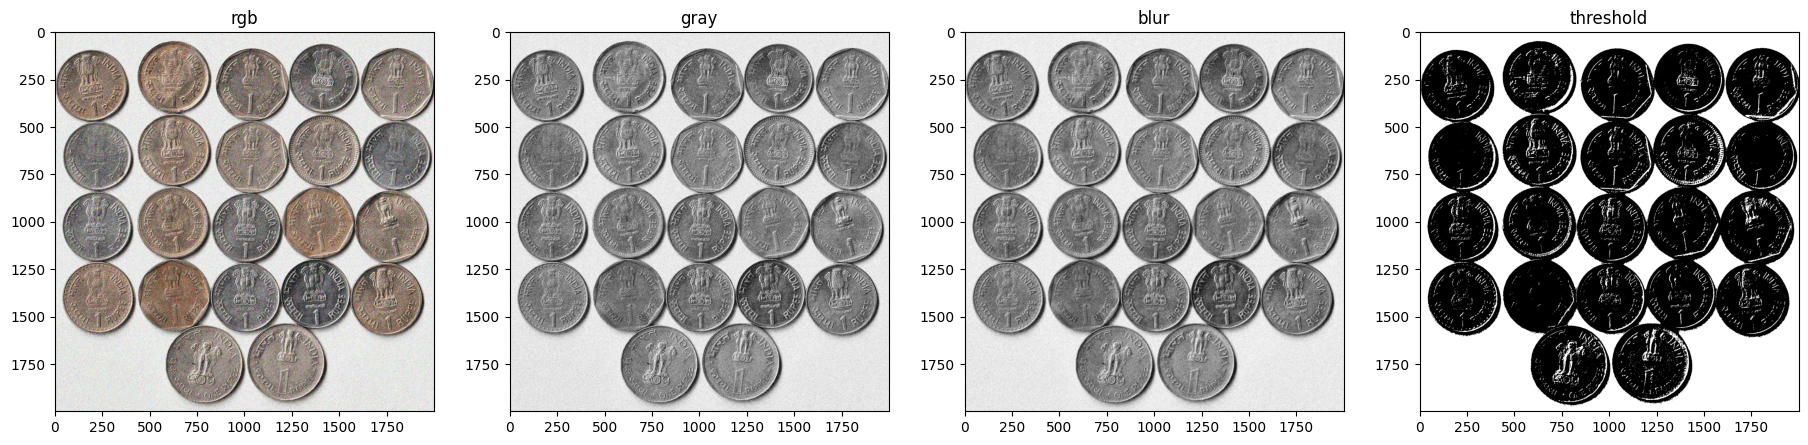

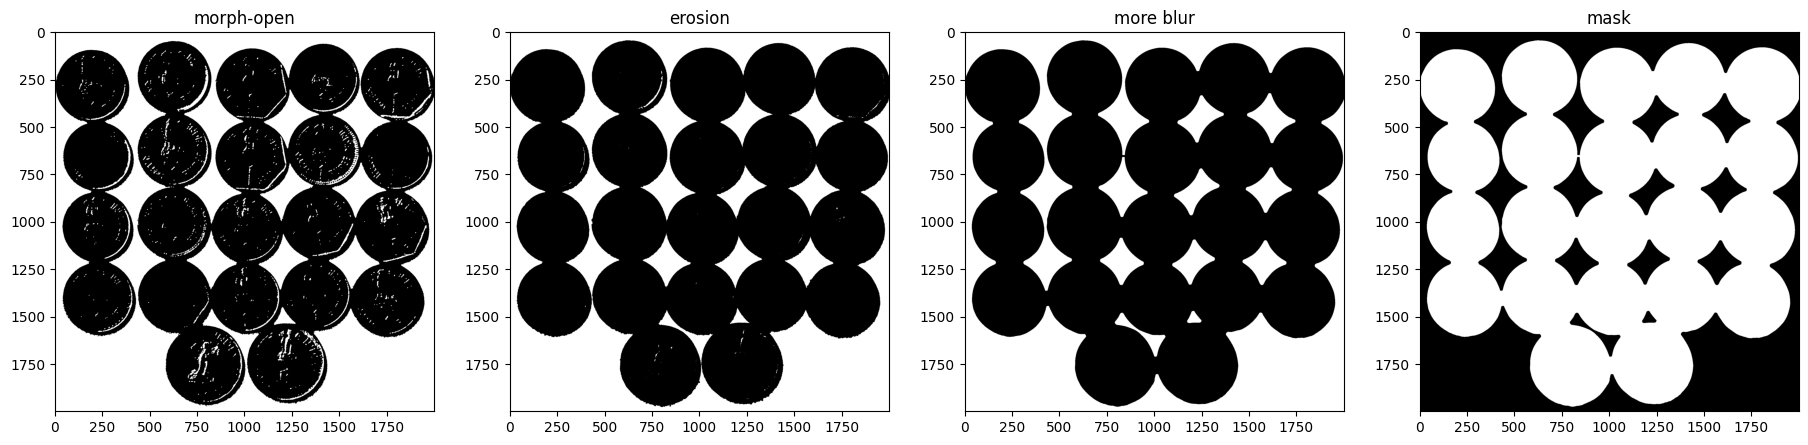

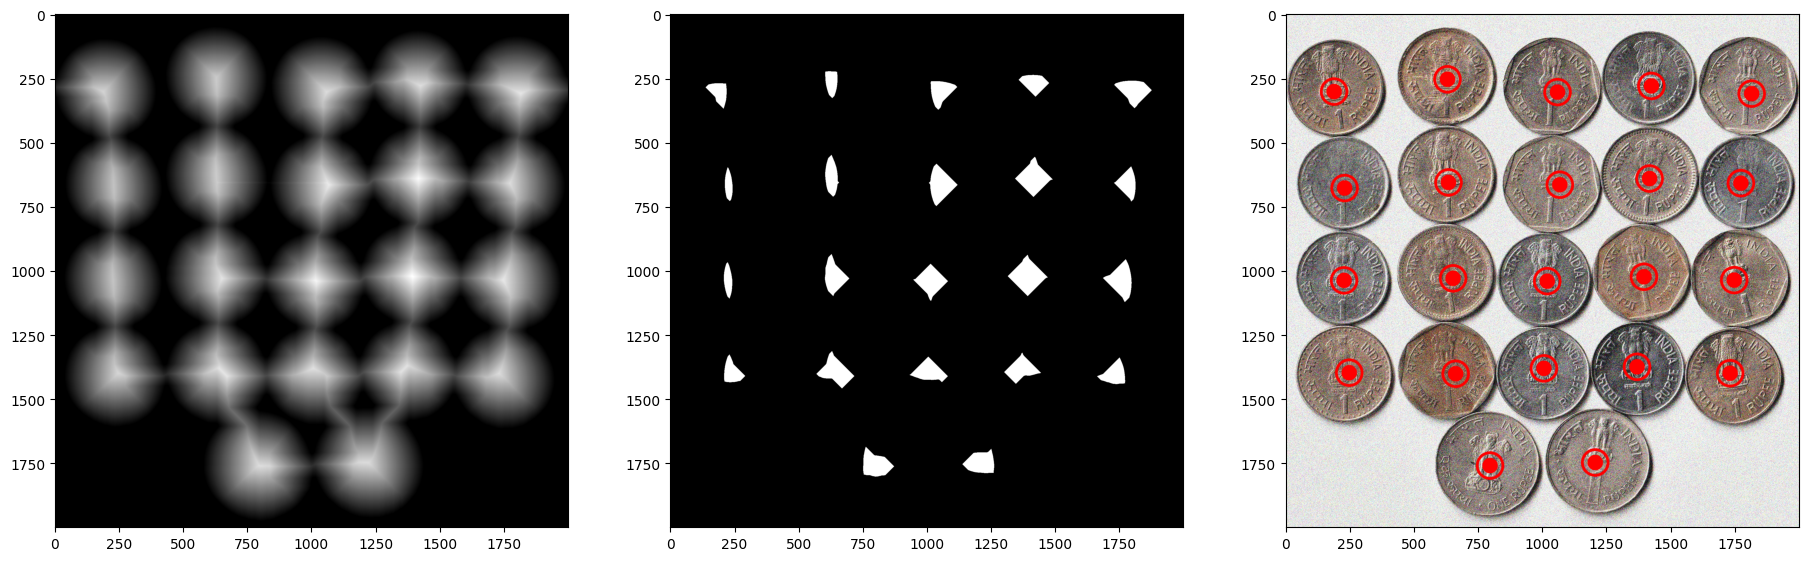

Detected:  22


In [25]:
# Load image
coins_bgr = cv2.imread("coins.jpg", cv2.IMREAD_COLOR)
coins_rgb = cv2.cvtColor(coins_bgr, cv2.COLOR_BGR2RGB)
coins_gray = cv2.cvtColor(coins_bgr, cv2.COLOR_BGR2GRAY)

# Blur to get rid of basic noise
coins_blur = cv2.GaussianBlur(coins_gray, (5,5),0)

# Threshold font
_,coins_thresh = cv2.threshold(coins_blur,0,255,cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Just for demonstration
showInRow([coins_rgb,coins_gray, coins_blur,coins_thresh],['rgb','gray', 'blur', 'threshold'])

# We are still have a lot of noise, erosion
kernel_opcl = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
coins_open = cv2.morphologyEx(coins_thresh, cv2.MORPH_OPEN, kernel_opcl, iterations=2)

# Still noise!!! Just using erosion
kernel_eros = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9,9))
coins_eros = cv2.erode(coins_open, kernel_eros, iterations=1)

# Blur small gaps inside coins
coins_blur = cv2.medianBlur(coins_eros, 27)
coins_mask = cv2.bitwise_not(coins_blur)

# One more demonstration
showInRow([coins_open, coins_eros, coins_blur, coins_mask], ['morph-open','erosion','more blur','mask'])

# Let's mark the centers of 'light'
# coins_dist = cv2.distanceTransform(coins_mask,cv2.DIST_L2,5)    <-- is not allowed...
depth = np.zeros(coins_mask.shape)
cur = coins_mask.copy()
for i in range (1,  250):
  depth[cur>0] = i
  next = cv2.erode(cur,kernel_opcl,iterations=1)
  cur = next
coins_dist = (depth / (depth.max() + 1e-6))

# Limit space and make it white
peak_mask = coins_dist >= (coins_dist.max() * 0.7)

# Coordinates of maximums
ys, xs = np.where(peak_mask & (coins_mask > 0))
vals = coins_dist[ys, xs]

# Sort maximums and pick the needed ones
order = np.argsort(-vals)
centers = []
for i in order:
    y, x = int(ys[i]), int(xs[i])
    # Take it only if it's far away from another (by 150 pixels)
    if not centers or min(np.hypot(x - cx, y - cy) for (cx, cy) in centers) >= 150:
        centers.append((x, y))

# We can make it possible to see where are the coins were detected
coins_overlay = coins_rgb.copy()
for (x,y) in centers:
  cv2.circle(coins_overlay, (x,y), 50, (255,0,0), 10)
  cv2.circle(coins_overlay, (x,y), 10, (255,0,0), 40)

# Finally, the result!
showInRow([coins_dist, peak_mask ,coins_overlay])
print("Detected: ", len(centers))

## Lane Edges detection

In [9]:
# Download the image
!wget -O road.png "https://drive.google.com/uc?export=download&id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ"
!wget -O mask.png "https://drive.google.com/uc?export=download&id=1OuIWhp4mZjYO81IjzpVBs6yyp5ftXW0Z"

--2025-09-18 07:09:28--  https://drive.google.com/uc?export=download&id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ
Resolving drive.google.com (drive.google.com)... 108.177.97.113, 108.177.97.138, 108.177.97.102, ...
Connecting to drive.google.com (drive.google.com)|108.177.97.113|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ&export=download [following]
--2025-09-18 07:09:29--  https://drive.usercontent.google.com/download?id=18GKJNJVQfM8lvSu6kaM4tFY-pJKrzJyJ&export=download
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 142.251.170.132, 2404:6800:4008:c05::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|142.251.170.132|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 387475 (378K) [image/png]
Saving to: ‘road.png’

road.png            100%[===================>] 378.39K  --.-KB/s    in 0.003s  

202

## **Explanation of the Process**

1. **Region of Interest (ROI) mask**
First, I created a triangular mask that covers the road area in the image.

* I defined three points: bottom-left, bottom-right, and the top middle of the road.
* With `cv2.fillPoly` I filled this triangle to make a binary mask (white inside ROI, black outside).
This mask helps us focus only on the road and ignore irrelevant edges on the background.

2. **Canny edge detector (custom implementation)**
I implemented Canny from scratch, step by step:

* **Grayscale**: convert the road image to gray so we work on intensity only.
* **Gradients**: compute Sobel X and Sobel Y filters to measure horizontal and vertical changes.
* **Magnitude**: combine the two gradients to know how strong the edge is.
* **Direction quantization**: reduce edge directions to four categories (0°, 45°, 90°, 135°).
* **Non-Maximum Suppression (NMS)**: thin the edges by keeping only local maxima along the gradient direction. This removes thick edges and keeps them one pixel wide.
* **Double thresholding**: classify pixels into **strong edges** (above high threshold), **weak edges** (between low and high), and discard the rest.
* **Hysteresis (disambiguation)**: start from strong edges and follow weak edges that are connected to them. If a weak edge is isolated, it is removed. This step keeps continuous lines and removes noise.

3. **Apply mask to edges**
After detecting edges, I used the ROI mask with `cv2.bitwise_and`. This keeps only the edges inside the triangle region of the road. As a result, the final image highlights road boundaries while ignoring other parts of the image.

## **Results**

* The pipeline detected clear edges along the road.
* The ROI mask ensured that only the lower central part of the image was considered, so trees, buildings, and sky were ignored.
* The combination of NMS and hysteresis produced thin and connected lines, which are suitable for road detection tasks.


(540, 960) <class 'numpy.ndarray'> <class 'numpy.uint8'>


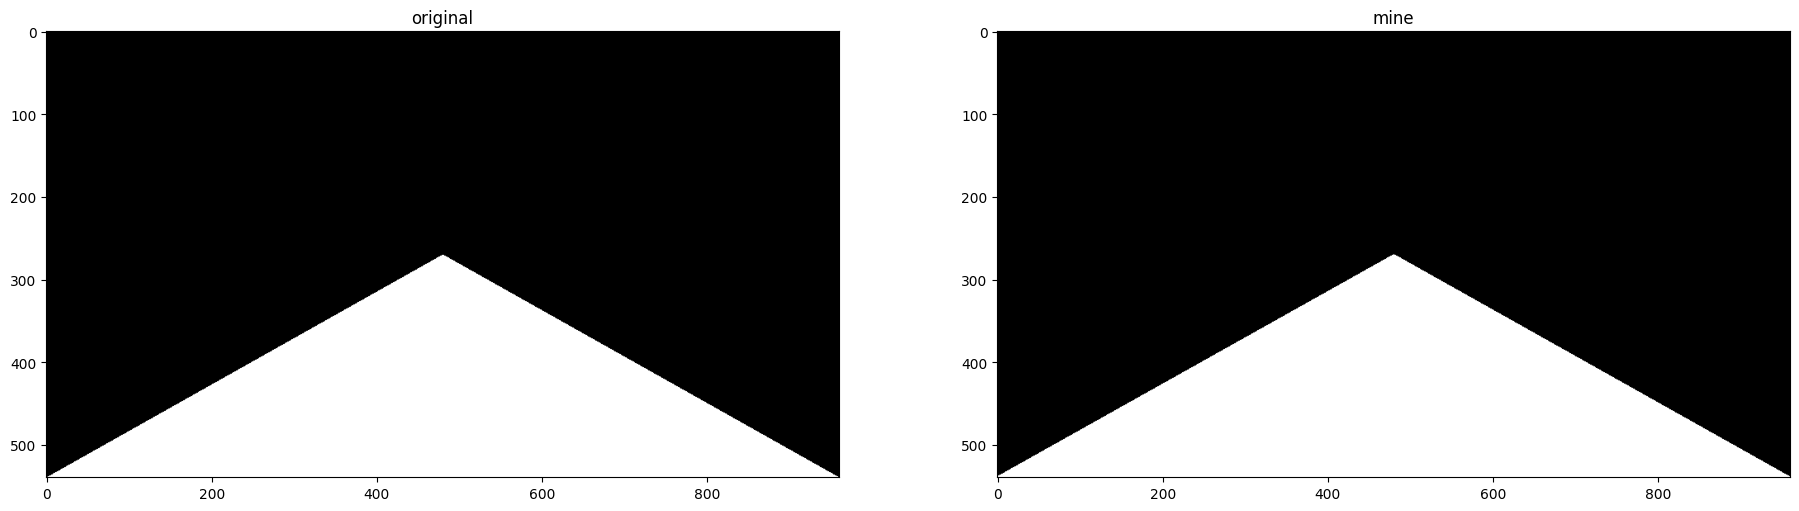

In [22]:
mask_original = cv2.imread("mask.png", cv2.IMREAD_COLOR)

H, W, _ = mask_original.shape

# Generate mask for ROI (Region of Interest)
mask = np.zeros((H, W))
pts = np.array([[0, H-1], [W-1, H-1], [W//2, H//2]])
cv2.fillPoly(mask, [pts], 255)
mask = (mask > 0).astype(np.uint8) * 255
print(mask.shape, type(mask),type(mask[0,0]))
showInRow([mask_original, mask],['original', 'mine'])

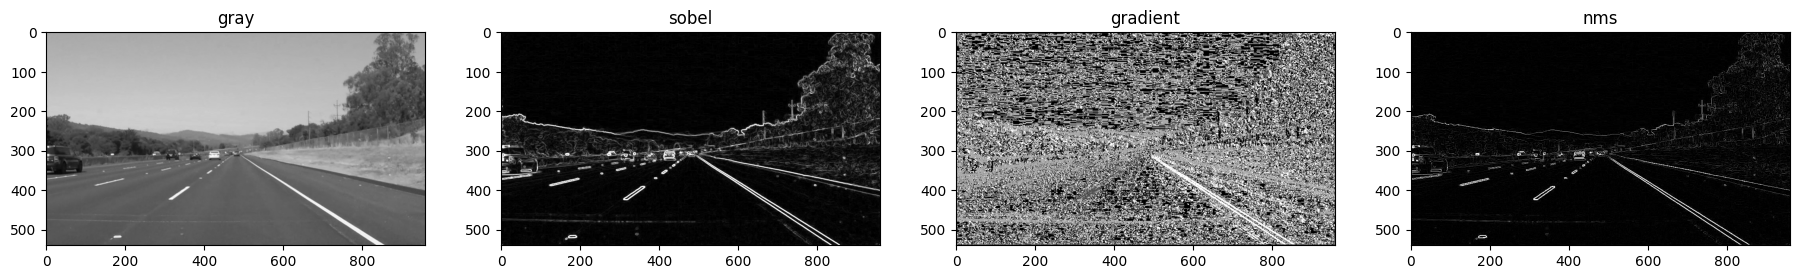

(540, 960) <class 'numpy.ndarray'> <class 'numpy.uint8'>


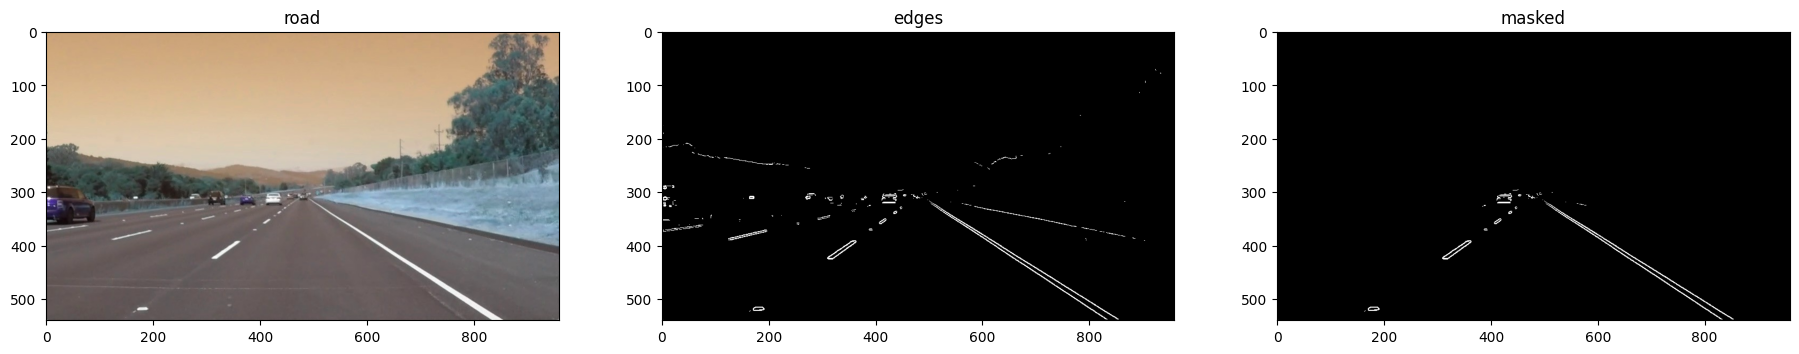

In [23]:
# non maximum suppression
# to keep the actual edges, that we need by knowing gradients
def nms_basic(mag, dir_bins):
    H, W = mag.shape
    out = np.zeros_like(mag, dtype=mag.dtype)
    for y in range(1, H-1):
        for x in range(1, W-1):
            m = mag[y, x]
            d = dir_bins[y, x]

            # left-right
            if d == 0:
                a, b = mag[y, x-1], mag[y, x+1]

            # 45 (up-right / down-left)
            elif d == 1:
                a, b = mag[y-1, x+1], mag[y+1, x-1]

            # up-down
            elif d == 2:
                a, b = mag[y-1, x], mag[y+1, x]

            # 135 (up-left / down-right)
            else:
                a, b = mag[y-1, x-1], mag[y+1, x+1]
            if m >= a and m >= b:
                out[y, x] = m
    return out

# helps to find and apply gradients, that will point to the edges
def quantize_dirs(gx, gy):
    # angle in [0,180)
    ang = (np.rad2deg(np.arctan2(gy, gx)) + 180) % 180
    d = np.zeros_like(ang, np.uint8)
    d[(ang < 22.5) | (ang >= 157.5)] = 0 # 0
    d[(ang >= 22.5) & (ang < 67.5)]  = 1 # 45
    d[(ang >= 67.5) & (ang < 112.5)] = 2 # 90
    d[(ang >= 112.5) & (ang < 157.5)] = 3 # 135
    return d

# was useful to check https://docs.opencv.org/4.x/da/d22/tutorial_py_canny.html (i don't wanna get ai plagiarism so, here is the reference)
def Canny(image, t, T):
  # convert image to grayscale, if it is not gray
  if len(image.shape) == 3:
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

  # find sobelX and sobelY, use cv2.Sobel
  sobx=cv2.Sobel(image,cv2.CV_64F,1,0,ksize=3)
  soby=cv2.Sobel(image,cv2.CV_64F,0,1,ksize=3)

  # find gradient magnitudes from sobelx and sobely
  magn = cv2.magnitude(sobx,soby)
  magn = cv2.convertScaleAbs(magn)

  # find gradient directions, use np.arctan2(x1, x2) - will give you arc tangent of x1/x2
  # take only one part of theta
  grad = quantize_dirs(sobx,soby)

  # non maximum suppression
  nms = nms_basic(magn,grad)

  # double threshold
  # double threshold masks
  strong = (nms >= T)
  weak   = (nms >= t) & (nms < T)

  # disambiguation area trace
  res = np.zeros(nms.shape, dtype=np.uint8)
  visited = np.zeros(nms.shape)
  stack = list(zip(*np.where(strong)))
  while stack:
    y, x = stack.pop()
    if visited[y, x]:
      continue
    visited[y, x] = True
    res[y, x] = 255
    for ny in (y-1, y, y+1):
      for nx in (x-1, x, x+1):
        if ny == y and nx == x:
          continue
        if 0 <= ny < H and 0 <= nx < W:
          if weak[ny, nx] and not visited[ny, nx]:
            stack.append((ny, nx))


  # show the steps
  showInRow([image,magn,grad,nms],['gray','sobel','gradient','nms'])
  return res

road_image = cv2.imread("road.png")
edges = Canny(road_image, 250, 255)
masked = cv2.bitwise_and(edges,mask)

showInRow([road_image, edges, masked],['road','edges','masked'])
